#### <i> PODSUMOWANIE: 
    Zrealizowano całe zadanie.

# Optymalizacje w Julii

## 1. Prosty program - testowanie działanie profilera.

In [52]:
function fun1()
  for i in 1:100
    string(MersenneTwister(i))
  end
end

fun1 (generic function with 1 method)

In [53]:
function fun2()
  for i in 1:10
    string(MersenneTwister(i))
  end
end

fun2 (generic function with 1 method)

In [54]:
function myfun()
  for i in 1:500
    fun1()
    fun2()
  end
end

myfun (generic function with 1 method)

In [55]:
@time fun1()

  0.847786 seconds (454.88 k allocations: 24.474 MiB, 0.87% gc time)


In [56]:
@time fun2()

  0.013672 seconds (17.39 k allocations: 1.040 MiB)


In [57]:
Profile.clear()
@profile myfun()

In [58]:
Profile.print(format=:flat)

 Count File                        Line Function                               
 10892 ./<missing>                   -1 anonymous                              
     1 ./In[52]                       2 fun1()                                 
  9909 ./In[52]                       3 fun1()                                 
   982 ./In[53]                       3 fun2()                                 
  9910 ./In[54]                       3 myfun()                                
   982 ./In[54]                       4 myfun()                                
     1 ./abstractarray.jl            71 indices1                               
     1 ./abstractarray.jl            64 indices                                
     1 ./abstractarray.jl            99 linearindices                          
     1 ./array.jl                   227 fill!(::Array{Int32,1}, ::Int32)       
    15 ./array.jl                   228 fill!(::Array{Float64,1}, ::Float64)   
    14 ./array.jl                   104 

    14 ./iobuffer.jl                348 write                                  
    13 ./iobuffer.jl                349 write                                  
    61 ./iobuffer.jl                352 write                                  
    16 ./iobuffer.jl                354 write                                  
     7 ./iobuffer.jl                355 write                                  
    21 ./iobuffer.jl                356 write                                  
 10892 ./loading.jl                 522 include_string(::String, ::String)     
     2 ./pair.jl                      4 Pair(::Symbol, ::MersenneTwister)      
     2 ./pointer.jl                  37 unsafe_convert                         
 10892 ./profile.jl                  23 macro expansion                        
    25 ./promotion.jl               249 +                                      
    15 ./promotion.jl               251 -                                      
    23 ./promotion.jl               304 

In [59]:
@allocated myfun()

5648720000

In [60]:
@time myfun()

 14.582760 seconds (89.16 M allocations: 5.261 GiB, 3.52% gc time)


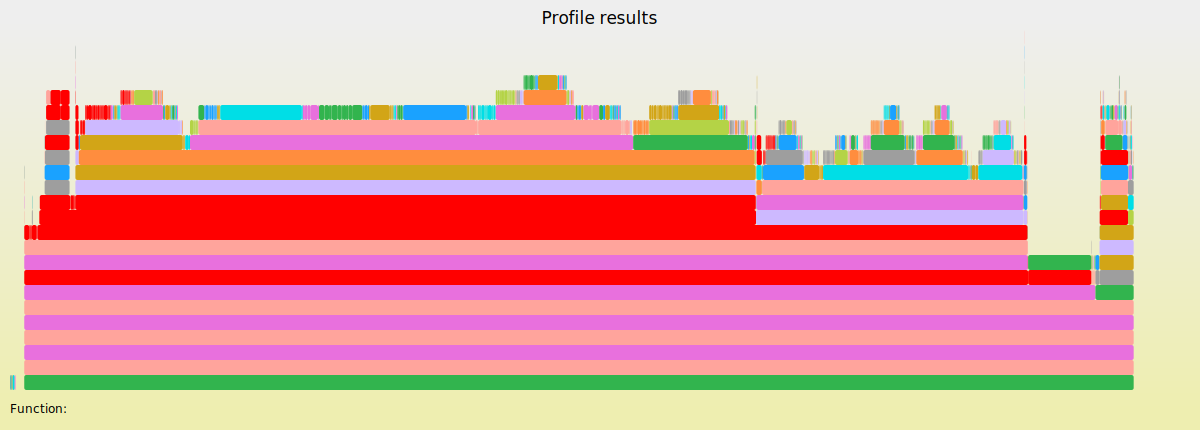

In [61]:
using ProfileView
ProfileView.view()

## 2. Optymalizowanie pod kątem wydajności 


### Wnioski:
- Znaczne poprawienie wydajności przyniosła zmiana sposobu inicjalizacji grafu (1).
<br>
- Dobrą optymalizacją była także zmiana w funkcji graph_to_str (5).
<br>
- Pozostałe zmiany - usunięcie zmiennych globalnych (2), dodanie deklaracji typów (3) i dodanie adnotacji (4) - 
<br>
w znacznie mniejszym stopniu, ale także poprawiły wydajność.
<br> <br>
Udało się osiągnąć zmianę ~ 14 sek -> 1 sek

Niezoptymalizowany program

In [1]:
module Graphs

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph()
    A = Array{Int64,2}(N, N)

    for i=1:N, j=1:N
      A[i,j] = 0
    end

    for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      A[row,col] = 1
      A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes = Vector()
  for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  for i = 1:N, j = 1:N
      if A[i,j] == 1
        push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition()
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler()
  if length(partition()) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str()
  graph_str = ""
  for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  for i=1:100
    global graph = GraphVertex[]

    A = generate_random_graph()
    nodes = generate_random_nodes()
    convert_to_graph(A, nodes)

    str = graph_to_str()
#     println(str)
#     println(check_euler())
    check_euler()
  end
end

end

Graphs

In [2]:
# import Graphs

In [3]:
Graphs.test_graph()# kompilacja (za pierwszym razem wykonanie trwa dluzej)

In [4]:
@time Graphs.test_graph()

 16.165210 seconds (121.82 M allocations: 6.525 GiB, 11.78% gc time)


In [5]:
@allocated Graphs.test_graph()

7006513376

In [6]:
Profile.clear()

In [7]:
@profile Graphs.test_graph()

In [8]:
Profile.print(format=:flat)

 Count File                        Line Function                               
 12751 ./<missing>                   -1 anonymous                              
     4 ./In[1]                       78 #1                                     
     1 ./In[1]                      112 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
     1 ./In[1]                      113 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
    45 ./In[1]                      115 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
   130 ./In[1]                      116 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
     4 ./In[1]                      117 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
    31 ./In[1]                      118 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
     5 ./In[1]                      119 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
     4 ./In[1]                      120 #bfs#3(::Set{Any}, ::Set{Graphs.Gra... 
   235 ./In[1]                      130 check_euler()                          
     2 ./In[1]                      131 

     1 ./multidimensional.jl        525 macro expansion                        
     1 ./multidimensional.jl        527 macro expansion                        
 12751 ./profile.jl                  23 macro expansion                        
     2 ./random.jl                  125 mt_pop!                                
     7 ./random.jl                  682 rand!(::MersenneTwister, ::Array{In... 
     2 ./random.jl                  143 rand                                   
     2 ./random.jl                  282 rand                                   
     2 ./random.jl                  344 rand                                   
     1 ./random.jl                  620 rand(::MersenneTwister, ::Base.Rand... 
     1 ./random.jl                  622 rand(::MersenneTwister, ::Base.Rand... 
     7 ./random.jl                  630 rand(::MersenneTwister, ::Base.Rand... 
     2 ./random.jl                  697 rand                                   
     2 ./random.jl                  698 

In [9]:
#Pkg.add("ProfileView")
#Pkg.update()

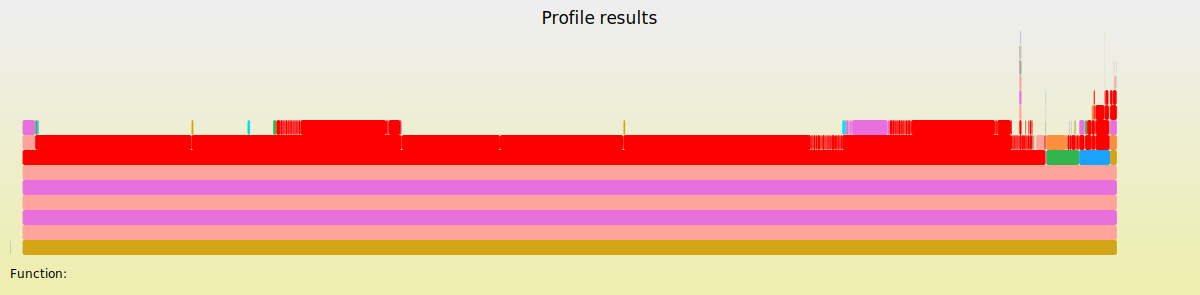

In [10]:
using ProfileView
ProfileView.view()

### 2.1. Zmiana sposobu inicjalizacji grafu

In [11]:
module Graphs1

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
##################################################
############### opt
##################################################
function generate_random_graph()
    A = zeros(N, N)

    for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      A[row,col] = 1
      A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes = Vector()
  for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  for i = 1:N, j = 1:N
      if A[i,j] == 1
        push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition()
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler()
  if length(partition()) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str()
  graph_str = ""
  for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  for i=1:100
    global graph = GraphVertex[]

    A = generate_random_graph()
    nodes = generate_random_nodes()
    convert_to_graph(A, nodes)

    str = graph_to_str()
    # println(str)
    check_euler()
  end
end

end

Graphs1

In [12]:
import Graphs1

In [13]:
Graphs1.test_graph()# kompilacja (za pierwszym razem wykonanie trwa dluzej)

In [14]:
@time Graphs1.test_graph()

  3.372137 seconds (13.29 M allocations: 3.983 GiB, 16.91% gc time)


In [15]:
@allocated Graphs1.test_graph()

4275508176

In [16]:
Profile.clear()
@profile Graphs1.test_graph()

In [17]:
Profile.print(format=:flat)

 Count File                        Line Function                               
  1910 ./<missing>                   -1 anonymous                              
     3 ./In[11]                      77 #1                                     
    32 ./In[11]                     114 #bfs#3(::Set{Any}, ::Set{Graphs1.Gr... 
   113 ./In[11]                     115 #bfs#3(::Set{Any}, ::Set{Graphs1.Gr... 
     4 ./In[11]                     116 #bfs#3(::Set{Any}, ::Set{Graphs1.Gr... 
    21 ./In[11]                     117 #bfs#3(::Set{Any}, ::Set{Graphs1.Gr... 
     9 ./In[11]                     118 #bfs#3(::Set{Any}, ::Set{Graphs1.Gr... 
     8 ./In[11]                     119 #bfs#3(::Set{Any}, ::Set{Graphs1.Gr... 
   204 ./In[11]                     129 check_euler()                          
     1 ./In[11]                     130 check_euler()                          
     7 ./In[11]                      77 convert_to_graph(::Array{Float64,2}... 
   170 ./In[11]                      80 

    10 ./set.jl                       7 Set{Graphs1.GraphVertex}(::Set{Grap... 
     5 ./set.jl                      10 Set(::Array{Graphs1.GraphVertex,1})    
     6 ./set.jl                      39 delete!(::Set{Graphs1.GraphVertex},... 
   138 ./set.jl                      34 in                                     
    73 ./set.jl                      35 push!                                  
    10 ./set.jl                      63 union!(::Set{Graphs1.GraphVertex}, ... 
     5 ./set.jl                      64 union!(::Set{Graphs1.GraphVertex}, ... 
    22 ./show.jl                    259 show                                   
     8 ./strings/io.jl               91 #print_to_string#229(::Void, ::Func... 
    45 ./strings/io.jl              102 #print_to_string#229(::Void, ::Func... 
     5 ./strings/io.jl              105 #print_to_string#229(::Void, ::Func... 
    22 ./strings/io.jl               29 print(::Base.AbstractIOBuffer{Array... 
     6 ./strings/io.jl              122 

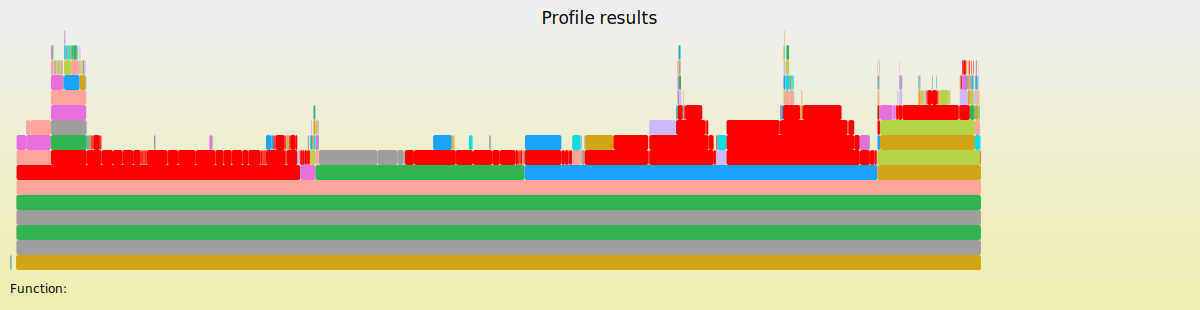

In [18]:
using ProfileView
ProfileView.view()

### 2.2. Usunięcie zmiennych globalnych

In [19]:
module Graphs2

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
##################################################
############### opt: zmienne globalne N,K - jako argumenty funkcji 
##################################################
function generate_random_graph(N, K)
    A = zeros(N, N)

    for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      A[row,col] = 1
      A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes(N)
  nodes = Vector()
  for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
##################################################
############### opt: zmienna globalna graph - jako argument funkcji 
##################################################
function convert_to_graph(A, nodes, graph)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  for i = 1:N, j = 1:N
      if A[i,j] == 1
        push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
##################################################
############### opt: zmienna globalna graph - jako argument funkcji 
##################################################
function partition(graph)
  parts = []
  remaining = Set(graph)
  visited = bfs(graph, remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(graph, visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
##################################################
############### opt: zmienna globalna graph - jako argument funkcji 
##################################################
function bfs(graph;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
##################################################
############### opt: zmienna globalna graph - jako argument funkcji 
##################################################
function check_euler(graph)
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
##################################################
############### opt: zmienna globalna graph - jako argument funkcji 
##################################################
function graph_to_str(graph)
  graph_str = ""
  for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  for i=1:100
###############################################################
############### opt: zmienne globalne
###############################################################
    graph = GraphVertex[]
    # Number of graph nodes.
    N = 800

    # Number of graph edges.
    K = 10000

    A = generate_random_graph(N, K)
    nodes = generate_random_nodes(N)
    convert_to_graph(A, nodes, graph)

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end

Graphs2

In [20]:
import Graphs2

In [21]:
Graphs2.test_graph()# kompilacja (za pierwszym razem wykonanie trwa dluzej)

In [22]:
@time Graphs2.test_graph()

  2.688352 seconds (3.85 M allocations: 3.763 GiB, 27.80% gc time)


In [23]:
@allocated Graphs2.test_graph()

4041981552

In [24]:
Profile.clear()
@profile Graphs2.test_graph()

In [25]:
Profile.print(format=:flat)

 Count File                        Line Function                               
  1122 ./<missing>                   -1 anonymous                              
    32 ./In[19]                     116 #bfs#3(::Set{Any}, ::Set{Graphs2.Gr... 
   102 ./In[19]                     117 #bfs#3(::Set{Any}, ::Set{Graphs2.Gr... 
    22 ./In[19]                     119 #bfs#3(::Set{Any}, ::Set{Graphs2.Gr... 
     9 ./In[19]                     120 #bfs#3(::Set{Any}, ::Set{Graphs2.Gr... 
     5 ./In[19]                     121 #bfs#3(::Set{Any}, ::Set{Graphs2.Gr... 
   186 ./In[19]                     134 check_euler(::Array{Graphs2.GraphVe... 
     1 ./In[19]                      75 convert_to_graph(::Array{Float64,2}... 
   131 ./In[19]                      76 convert_to_graph(::Array{Float64,2}... 
   114 ./In[19]                      77 convert_to_graph(::Array{Float64,2}... 
    93 ./In[19]                      37 generate_random_graph(::Int64, ::Int64)
    70 ./In[19]                      39 

     6 ./strings/io.jl              122 print(::Base.AbstractIOBuffer{Array... 
    70 ./strings/io.jl               91 print_to_string(::String, ::Vararg{... 
   141 ./strings/io.jl              120 string(::String, ::Int64, ::Vararg{... 
     1 ./strings/string.jl           43 _string_n                              
     1 ./strings/string.jl          155 endof(::String)                        
     1 ./strings/string.jl           51 pointer                                
     1 ./strings/string.jl           52 pointer                                
     1 ./strings/string.jl          320 string(::String, ::Vararg{String,N}... 
   139 ./strings/string.jl          326 string(::String, ::Vararg{String,N}... 
     2 ./strings/string.jl          329 string(::String, ::Vararg{String,N}... 
     2 ./strings/string.jl          330 string(::String, ::Vararg{String,N}... 
     6 ./strings/string.jl           71 write(::Base.AbstractIOBuffer{Array... 
  1123 ./task.jl                    335 

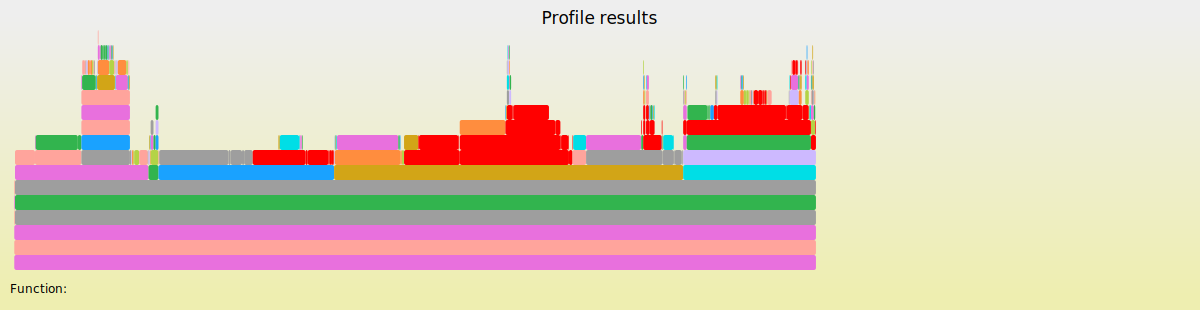

In [26]:
using ProfileView
ProfileView.view()

### 2.3. Dodanie deklaracji typów

In [27]:
module Graphs3

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name ::String
end

mutable struct Address <: NodeType
  streetNumber ::Int64
end

#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
##################################################
############### opt: typy
##################################################
function generate_random_graph(N::Int64, K::Int64)
    A = zeros(Int64, N, N)

    for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      A[row,col] = 1
      A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(Int8(1):Int8(100)))
end

# Generates N random nodes (of random NodeType).
##################################################
############### opt: typy
##################################################
function generate_random_nodes(N ::Int64)
  nodes = Vector{NodeType}()
  for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person()::NodeType : get_random_address()::NodeType)
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
##################################################
############### opt: typy
##################################################
function convert_to_graph(A:: Array{Int64,2}, nodes:: Array{NodeType,1}, graph:: Array{GraphVertex,1})
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  for i = 1:N, j = 1:N
      if A[i,j] == 1
        push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
##################################################
############### opt: typy
##################################################
function partition(graph:: Array{GraphVertex,1})
  parts = []
  remaining = Set(graph)
  visited = bfs(graph, remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(graph, visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
##################################################
############### opt: typy
##################################################
function bfs(graph::Array{GraphVertex,1}; visited::Set{GraphVertex}=Set{GraphVertex}(), remaining::Set{GraphVertex}=Set(graph)) 
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
##################################################
############### opt: typy
##################################################
function check_euler(graph:: Array{GraphVertex,1})
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
##################################################
############### opt: typy
##################################################
function graph_to_str(graph:: Array{GraphVertex,1})
  graph_str = ""
  for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  for i=1:100
#     graph = Array{GraphVertex,1}GraphVertex[]
    graph = GraphVertex[]
    # Number of graph nodes.
    N::Int64 = 800

    # Number of graph edges.
    K::Int64 = 10000

    A = generate_random_graph(N, K)
    nodes = generate_random_nodes(N)
    convert_to_graph(A, nodes, graph)

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end

Graphs3

In [28]:
import Graphs3

In [29]:
Graphs3.test_graph()# kompilacja (za pierwszym razem wykonanie trwa dluzej)

In [30]:
@time Graphs3.test_graph()

  2.459098 seconds (3.50 M allocations: 3.758 GiB, 29.47% gc time)


In [31]:
@allocated Graphs3.test_graph()

4035076208

In [32]:
Profile.clear()
@profile Graphs3.test_graph()

In [33]:
Profile.print(format=:flat)

 Count File                        Line Function                               
  1155 ./<missing>                   -1 anonymous                              
     2 ./In[27]                     116 #bfs#3(::Set{Graphs3.GraphVertex}, ... 
    30 ./In[27]                     118 #bfs#3(::Set{Graphs3.GraphVertex}, ... 
    90 ./In[27]                     119 #bfs#3(::Set{Graphs3.GraphVertex}, ... 
     2 ./In[27]                     120 #bfs#3(::Set{Graphs3.GraphVertex}, ... 
     3 ./In[27]                     121 #bfs#3(::Set{Graphs3.GraphVertex}, ... 
    10 ./In[27]                     122 #bfs#3(::Set{Graphs3.GraphVertex}, ... 
     6 ./In[27]                     123 #bfs#3(::Set{Graphs3.GraphVertex}, ... 
   154 ./In[27]                     136 check_euler(::Array{Graphs3.GraphVe... 
     1 ./In[27]                      75 convert_to_graph(::Array{Int64,2}, ... 
     1 ./In[27]                      77 convert_to_graph(::Array{Int64,2}, ... 
   152 ./In[27]                      78 

     1 ./strings/string.jl          328 string(::String, ::Vararg{String,N}... 
     1 ./strings/string.jl          329 string(::String, ::Vararg{String,N}... 
     2 ./strings/string.jl          330 string(::String, ::Vararg{String,N}... 
     9 ./strings/string.jl           71 write(::Base.AbstractIOBuffer{Array... 
  1155 ./task.jl                    335 (::IJulia.##14#17)()                   
     1 ...lia/lib/julia/sys.dylib    -1 #print_to_string#229(::Void, ::Func... 
  1155 ....6/Compat/src/Compat.jl   403 (::Compat.#inner#18{Array{Any,1},IJ... 
  1155 ...IJulia/src/eventloop.jl     8 eventloop(::ZMQ.Socket)                
  1155 .../src/execute_request.jl   158 execute_request(::ZMQ.Socket, ::IJu... 
    66 ...atsBase/src/sampling.jl   349 #sample!#126(::Bool, ::Bool, ::Func... 
     1 ...atsBase/src/sampling.jl   193 self_avoid_sample!(::MersenneTwiste... 
    21 ...atsBase/src/sampling.jl   197 self_avoid_sample!(::MersenneTwiste... 
    18 ...atsBase/src/sampling.jl   198 

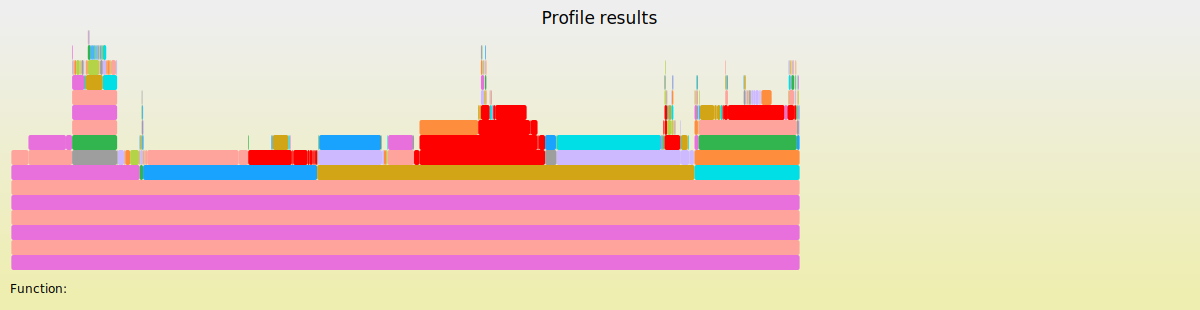

In [34]:
using ProfileView
ProfileView.view()

### 2.4. Dodanie adnotacji 
@simd @inbounds @elapsed

In [35]:
module Graphs4

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name ::String
end

mutable struct Address <: NodeType
  streetNumber ::Int64
end

#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
##################################################
############### opt
##################################################
function generate_random_graph(N::Int64, K::Int64)
    A = zeros(Int64, N, N)

    @simd for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      @inbounds A[row,col] = 1
      @inbounds A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(Int8(1):Int8(100)))
end

# Generates N random nodes (of random NodeType).
##################################################
############### opt
##################################################
function generate_random_nodes(N ::Int64)
  nodes = Vector{NodeType}()
  @simd for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person()::NodeType : get_random_address()::NodeType)
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
##################################################
############### opt
##################################################
function convert_to_graph(A:: Array{Int64,2}, nodes:: Array{NodeType,1}, graph:: Array{GraphVertex,1})
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  @elapsed for i = 1:N, j = 1:N
      @inbounds if A[i,j] == 1
        @inbounds push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition(graph:: Array{GraphVertex,1})
  parts = []
  remaining = Set(graph)
  visited = bfs(graph, remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(graph, visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
##################################################
############### opt
##################################################
function bfs(graph::Array{GraphVertex,1}; visited::Set{GraphVertex}=Set{GraphVertex}(), remaining::Set{GraphVertex}=Set(graph)) 
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    @simd for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler(graph:: Array{GraphVertex,1})
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
##################################################
############### opt
##################################################
function graph_to_str(graph:: Array{GraphVertex,1})
  graph_str = ""
  @simd for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
    @simd for i=1:100
    graph = GraphVertex[]
    # Number of graph nodes.
    N::Int64 = 800

    # Number of graph edges.
    K::Int64 = 10000

    A = generate_random_graph(N, K)
    nodes = generate_random_nodes(N)
    convert_to_graph(A, nodes, graph)

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end

Graphs4

In [36]:
import Graphs4

In [37]:
Graphs4.test_graph()# kompilacja (za pierwszym razem wykonanie trwa dluzej)

In [38]:
@time Graphs4.test_graph()

  2.440218 seconds (3.50 M allocations: 3.759 GiB, 28.87% gc time)


In [39]:
@allocated Graphs4.test_graph()

4035009488

In [40]:
Profile.clear()
@profile Graphs4.test_graph()

In [41]:
Profile.print(format=:flat)

 Count File                        Line Function                               
  1163 ./<missing>                   -1 anonymous                              
     3 ./In[35]                      75 #1                                     
     1 ./In[35]                     113 #bfs#3(::Set{Graphs4.GraphVertex}, ... 
   161 ./In[35]                     115 #bfs#3(::Set{Graphs4.GraphVertex}, ... 
   173 ./In[35]                     130 check_euler(::Array{Graphs4.GraphVe... 
     6 ./In[35]                      75 convert_to_graph(::Array{Int64,2}, ... 
   238 ./In[35]                      77 convert_to_graph(::Array{Int64,2}, ... 
    97 ./In[35]                      36 generate_random_graph(::Int64, ::Int64)
    85 ./In[35]                      38 generate_random_graph(::Int64, ::Int64)
    16 ./In[35]                      62 generate_random_nodes(::Int64)         
     2 ./In[35]                      53 get_random_address                     
     9 ./In[35]                      48 

     3 ./iobuffer.jl                327 unsafe_write(::Base.AbstractIOBuffe... 
     1 ./iterators.jl               188 next                                   
  1163 ./loading.jl                 522 include_string(::String, ::String)     
     3 ./multidimensional.jl        491 _getindex                              
     3 ./multidimensional.jl        506 _unsafe_getindex(::IndexLinear, ::A... 
     3 ./multidimensional.jl        495 macro expansion                        
     3 ./multidimensional.jl        511 macro expansion                        
  1163 ./profile.jl                  23 macro expansion                        
     1 ./random.jl                  560 Type                                   
     1 ./random.jl                  580 Base.Random.RangeGenerator(::UnitRa... 
     2 ./random.jl                  128 gen_rand                               
     1 ./random.jl                  547 maxmultiple(::UInt32)                  
     2 ./random.jl                  125 

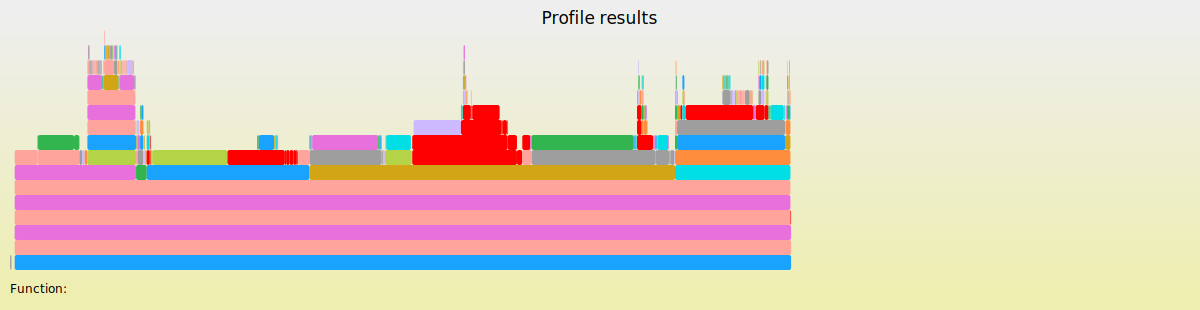

In [42]:
using ProfileView
ProfileView.view()

### 2.5. Drobne zmiany w kodzie
Najpierw tworzenie IOBuffer, a dopiero potem zamiana na stringa (bo string jest niemutowalny)

In [43]:
import Graphs5

LoadError: [91mArgumentError: Module Graphs5 not found in current path.
Run `Pkg.add("Graphs5")` to install the Graphs5 package.[39m

In [44]:
module Graphs5

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name ::String
end

mutable struct Address <: NodeType
  streetNumber ::Int64
end

#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph(N::Int64, K::Int64)
    A = zeros(Int64, N, N)

    @simd for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      @inbounds A[row,col] = 1
      @inbounds A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(Int8(1):Int8(100)))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes(N ::Int64)
  nodes = Vector{NodeType}()
  @simd for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person()::NodeType : get_random_address()::NodeType)
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A:: Array{Int64,2}, nodes:: Array{NodeType,1}, graph:: Array{GraphVertex,1})
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  @elapsed for i = 1:N, j = 1:N
      @inbounds if A[i,j] == 1
        @inbounds push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition(graph:: Array{GraphVertex,1})
  parts = []
  remaining = Set(graph)
  visited = bfs(graph, remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(graph, visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(graph::Array{GraphVertex,1}; visited::Set{GraphVertex}=Set{GraphVertex}(), remaining::Set{GraphVertex}=Set(graph)) 
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    @simd for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler(graph:: Array{GraphVertex,1})
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
##################################################
############### opt - rozbicie na mniejsze funkcje
##################################################
function value_to_buf(graph_buf::IOBuffer, n::Person)
  print(graph_buf, "****\nPerson: ", n.name)
end

function value_to_buf(graph_buf::IOBuffer, n::Address)
  print(graph_buf, "****\nStreet nr: ", n.streetNumber)
end

function graph_to_str(graph::Array{GraphVertex,1})
  graph_buf = IOBuffer()
  for v in graph
    value_to_buf(graph_buf, v.value)
    print(graph_buf, "\nNeighbors: ", length(v.neighbors), "\n")
  end
    String(take!(graph_buf))
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
    @simd for i=1:100
    graph = GraphVertex[]
    # Number of graph nodes.
    N::Int64 = 800

    # Number of graph edges.
    K::Int64 = 10000

    A = generate_random_graph(N, K)
    nodes = generate_random_nodes(N)
    convert_to_graph(A, nodes, graph)

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end

Graphs5

In [45]:
import Graphs5

In [46]:
Graphs5.test_graph()# kompilacja (za pierwszym razem wykonanie trwa dluzej)

In [47]:
@time Graphs5.test_graph()

  0.857502 seconds (2.70 M allocations: 646.195 MiB, 11.69% gc time)


In [48]:
@allocated Graphs5.test_graph()

677666976

In [49]:
Profile.clear()
@profile Graphs5.test_graph()

In [50]:
Profile.print(format=:flat)

 Count File                        Line Function                               
   700 ./<missing>                   -1 anonymous                              
     1 ./In[44]                      66 #1                                     
     1 ./In[44]                     119 #4                                     
     1 ./In[44]                     101 #bfs#3(::Set{Graphs5.GraphVertex}, ... 
   153 ./In[44]                     103 #bfs#3(::Set{Graphs5.GraphVertex}, ... 
   172 ./In[44]                     118 check_euler(::Array{Graphs5.GraphVe... 
     1 ./In[44]                     119 check_euler(::Array{Graphs5.GraphVe... 
     5 ./In[44]                      66 convert_to_graph(::Array{Int64,2}, ... 
   236 ./In[44]                      68 convert_to_graph(::Array{Int64,2}, ... 
   135 ./In[44]                      33 generate_random_graph(::Int64, ::Int64)
    90 ./In[44]                      35 generate_random_graph(::Int64, ::Int64)
    18 ./In[44]                      56 

    12 ./show.jl                    259 show                                   
    75 ./simdloop.jl                 65 macro expansion                        
     7 ./simdloop.jl                 67 macro expansion                        
     1 ./simdloop.jl                 68 macro expansion                        
    26 ./simdloop.jl                 72 macro expansion                        
   852 ./simdloop.jl                 73 macro expansion                        
    26 ./simdloop.jl                 50 simd_index                             
     2 ./strings/io.jl               28 print(::Base.AbstractIOBuffer{Array... 
    13 ./strings/io.jl               29 print(::Base.AbstractIOBuffer{Array... 
     2 ./strings/io.jl               38 print(::Base.AbstractIOBuffer{Array... 
    30 ./strings/io.jl               40 print(::Base.AbstractIOBuffer{Array... 
     2 ./strings/io.jl              122 print(::Base.AbstractIOBuffer{Array... 
     2 ./strings/io.jl              122 

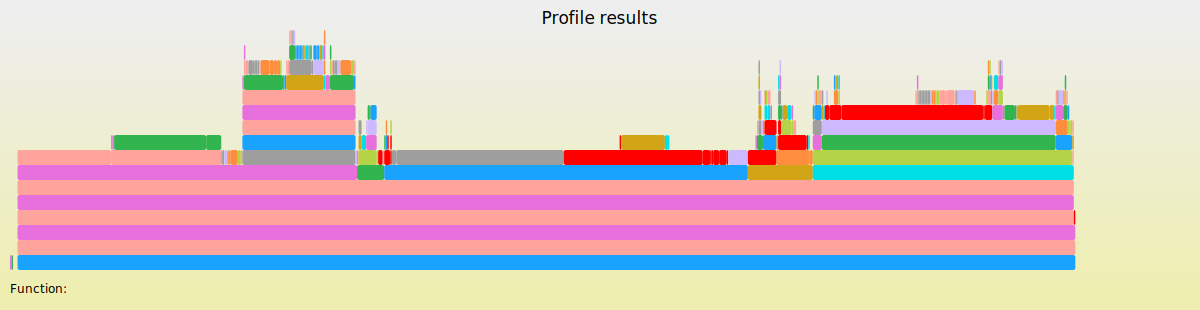

In [51]:
using ProfileView
ProfileView.view()